In [279]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import scipy
from warnings import filterwarnings
from xgboost import XGBClassifier

In [280]:
filterwarnings('ignore')
data = pd.read_csv('Datasets/hospital_readmissions_30k.csv')

In [281]:
data

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,29,Male,112/80,157,31.4,No,No,4,10,Home,Yes
29996,29997,20,Other,146/83,198,30.2,No,Yes,4,1,Home,Yes
29997,29998,40,Other,131/96,275,23.3,Yes,Yes,7,2,Home,No
29998,29999,61,Other,124/75,232,34.3,No,No,5,3,Home,No


In [282]:
data.columns

Index(['patient_id', 'age', 'gender', 'blood_pressure', 'cholesterol', 'bmi',
       'diabetes', 'hypertension', 'medication_count', 'length_of_stay',
       'discharge_destination', 'readmitted_30_days'],
      dtype='object')

In [283]:
dt = data.dtypes
dt = dt[dt == 'object']
dt

gender                   object
blood_pressure           object
diabetes                 object
hypertension             object
discharge_destination    object
readmitted_30_days       object
dtype: object

In [284]:
data.isna().sum()

patient_id               0
age                      0
gender                   0
blood_pressure           0
cholesterol              0
bmi                      0
diabetes                 0
hypertension             0
medication_count         0
length_of_stay           0
discharge_destination    0
readmitted_30_days       0
dtype: int64

In [285]:
le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])
data['diabetes'] = le.fit_transform(data['diabetes'])
data['hypertension'] = le.fit_transform(data['hypertension'])
data['discharge_destination'] = le.fit_transform(data['discharge_destination'])
data['readmitted_30_days'] = le.fit_transform(data['readmitted_30_days'])

data

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,2,130/72,240,31.5,1,0,5,1,1,1
1,2,46,0,120/92,292,36.3,0,0,4,3,1,0
2,3,89,2,135/78,153,30.3,0,1,1,1,0,0
3,4,84,0,123/80,153,31.5,0,1,3,10,0,0
4,5,32,2,135/84,205,18.4,0,1,6,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,29,1,112/80,157,31.4,0,0,4,10,0,1
29996,29997,20,2,146/83,198,30.2,0,1,4,1,0,1
29997,29998,40,2,131/96,275,23.3,1,1,7,2,0,0
29998,29999,61,2,124/75,232,34.3,0,0,5,3,0,0


In [286]:
"""Converting BP class into Min and Max recorded BP """

data['BloodPressure(Min)'] = data['blood_pressure'].apply(

    lambda x: 
        int(x.split('/')[1])
)

data['BloodPressure(Max)'] = data['blood_pressure'].apply(

    lambda x: 
        int(x.split('/')[0])
)
data.drop(columns=['blood_pressure'], inplace=True, axis=0)
data['bmi'] = data['bmi'].astype(int)

data

,patient_id,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,BloodPressure(Min),BloodPressure(Max)
0,1,74,2,240,31,1,0,5,1,1,1,72,130
1,2,46,0,292,36,0,0,4,3,1,0,92,120
2,3,89,2,153,30,0,1,1,1,0,0,78,135
3,4,84,0,153,31,0,1,3,10,0,0,80,123
4,5,32,2,205,18,0,1,6,4,1,0,84,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,29,1,157,31,0,0,4,10,0,1,80,112
29996,29997,20,2,198,30,0,1,4,1,0,1,83,146
29997,29998,40,2,275,23,1,1,7,2,0,0,96,131
29998,29999,61,2,232,34,0,0,5,3,0,0,75,124


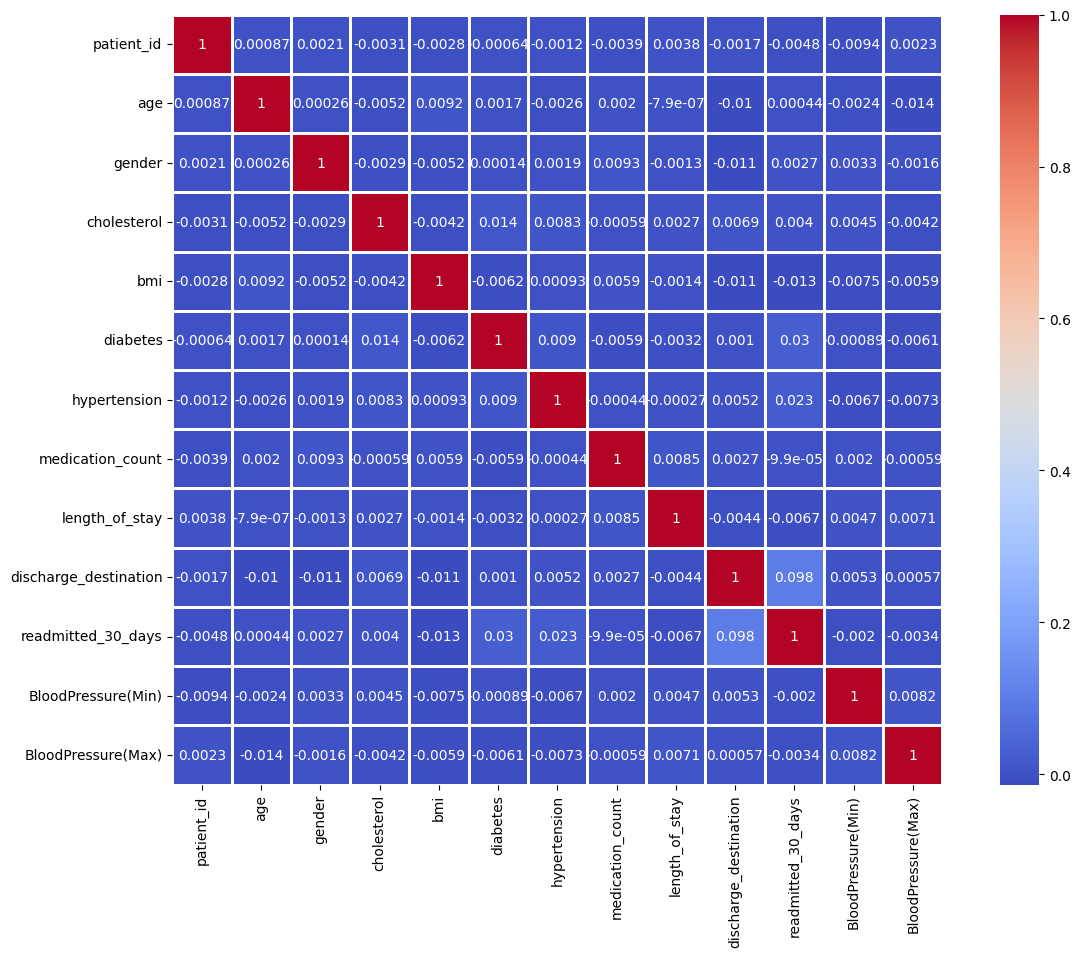

In [287]:
correlate = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(data=correlate, cmap='coolwarm', annot=True, square=True, linewidths=1)
plt.show()

In [288]:
""" Initial Model using Logistic Regression """

X = data.drop(columns=['readmitted_30_days'])
y = data['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc * 100)

87.18333333333334


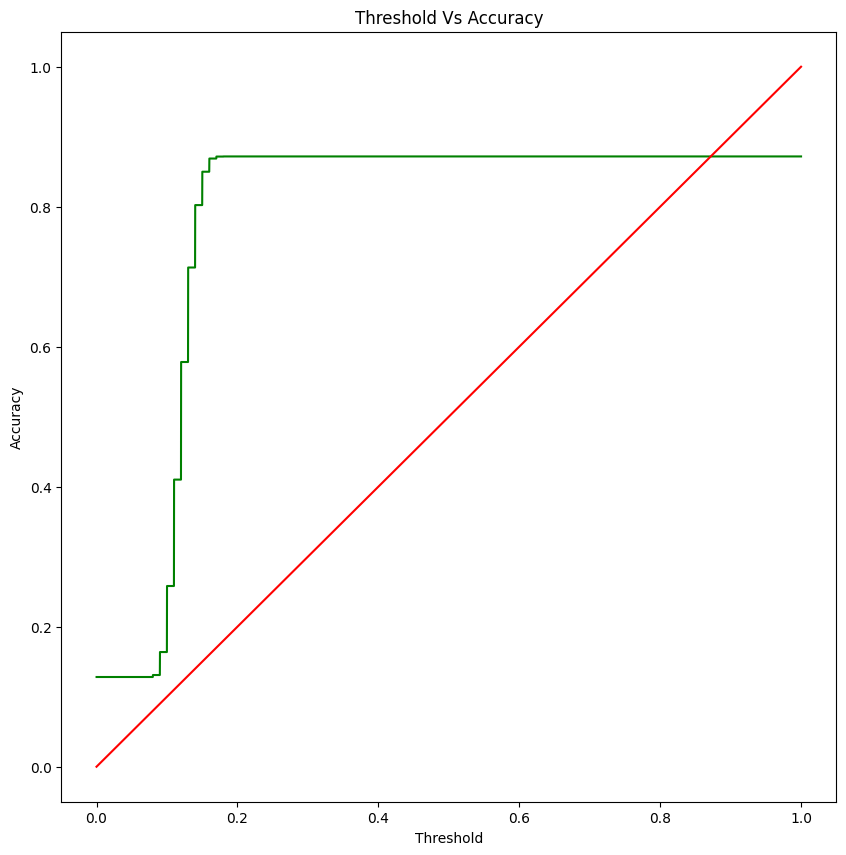

In [291]:
"""Threshold based Logistic Regression """

threshold = 0.0001
increment = 0.0001

y_pred_proba = pd.DataFrame(model.predict_proba(X_test)[:, 1])
y_proba_refined = y_proba_refined.apply(

    lambda y: round(y, 4)
)

thresh = []
accuracy = []

while threshold <= 1:

    y_pred = (y_proba_refined >= threshold)
    acc = accuracy_score(y_test, y_pred)

    thresh.append(threshold)
    accuracy.append(acc)
    threshold += increment

linLineX = np.linspace(0, 1, 10000)
linLineY = np.linspace(0, 1, 10000)

plt.figure(figsize=(10,10))

plt.plot(thresh, accuracy, c='g')
plt.plot(linLineX, linLineY, c='r', )
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold Vs Accuracy')
plt.show()

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5️⃣ Initialize SVM Classifier
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# 6️⃣ Train the model
svm_model.fit(X_train, y_train)

# 7️⃣ Make predictions
y_pred = svm_model.predict(X_test)

# 8️⃣ Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']  # You can also try 'linear', 'poly'
}

# 3️⃣ GridSearchCV for hyperparameter tuning
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

# 4️⃣ Best parameters
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# 5️⃣ Train final model with best parameters
best_svm = grid.best_estimator_
best_svm.fit(X_train_scaled, y_train)

# 6️⃣ Make predictions
y_pred = best_svm.predict(X_test_scaled)

# 7️⃣ Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 8️⃣ Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 9️⃣ Optional: Visualize GridSearch results as heatmap
results = pd.DataFrame(grid.cv_results_)
pivot_table = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
plt.figure(figsize=(6,5))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('Hyperparameter GridSearch Accuracy')
plt.ylabel('C')
plt.xlabel('Gamma')
plt.show()

Accuracy: 0.8718333333333333
Fitting 5 folds for each of 16 candidates, totalling 80 fits
